# Data Conditioning: Acquisition, Exploration, Cleaning, Encoding & Splitting

This section performs the Data Conditioning phase of the Machine Learning Pipeline.

Neural Networks require:


*   clean and consistent input patterns
*   numerical inputs
*   scaled features for stable gradient descent
*   training/validation/testing separation

This section prepares the UCI Predict Students Dropout and Academic Success dataset so it can be used as valid input to a Multilayer Perceptron (MLP) trained via backpropagation.

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Visualise the ANN

In [178]:
def visualise(mlp):
  # get number of neurons in each layer
  n_neurons = [len(layer) for layer in mlp.coefs_]
  n_neurons.append(mlp.n_outputs_)

  # calculate the coordinates of each neuron on the graph
  y_range = [0, max(n_neurons)]
  x_range = [0, len(n_neurons)]
  loc_neurons = [[[l, (n+1)*(y_range[1]/(layer+1))] for n in range(layer)] for l,layer in enumerate(n_neurons)]
  x_neurons = [x for layer in loc_neurons for x,y in layer]
  y_neurons = [y for layer in loc_neurons for x,y in layer]

  # identify the range of weights
  weight_range = [min([layer.min() for layer in mlp.coefs_]), max([layer.max() for layer in mlp.coefs_])]

  # prepare the figure
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  # draw the neurons
  ax.scatter(x_neurons, y_neurons, s=100, zorder=5)
  # draw the connections with line width corresponds to the weight of the connection
  for l,layer in enumerate(mlp.coefs_):
    for i,neuron in enumerate(layer):
      for j,w in enumerate(neuron):
        ax.plot([loc_neurons[l][i][0], loc_neurons[l+1][j][0]], [loc_neurons[l][i][1], loc_neurons[l+1][j][1]], 'white', linewidth=((w-weight_range[0])/(weight_range[1]-weight_range[0])*5+0.2)*1.2)
        ax.plot([loc_neurons[l][i][0], loc_neurons[l+1][j][0]], [loc_neurons[l][i][1], loc_neurons[l+1][j][1]], 'grey', linewidth=(w-weight_range[0])/(weight_range[1]-weight_range[0])*5+0.2)

# Data Collection

The dataset is obtained from the UCI Machine Learning Repository, fulfilling the “real-world data” criterion. This is also a supervised multi-class classification problem.

It contains demographic, academic, and socioeconomic features used to predict whether a student will:

*   Dropout
*   Enrol
*   Graduate



In [179]:
url = "https://archive.ics.uci.edu/static/public/697/data.csv"
df = pd.read_csv(url)

df.head()


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# Exploratory Data Analysis (EDA)

Networks learn from input patters, so before data can be used, it is important to:


*   understand feature types
*   inspect distributions
*   check for noise and inconsistencies
*   analyse target class balance
*   analyse relationships between features


This ensures the MLP receives well-understood, meaningful inputs.



In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [181]:
df.describe(include='all')

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Graduate
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2209
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969,NaN
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935,NaN
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,NaN
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000,NaN
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000,NaN
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000,NaN


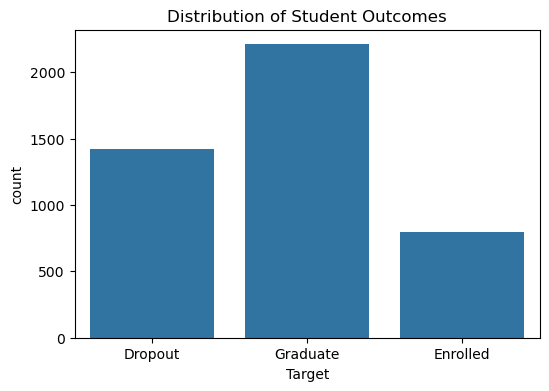

Target
Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: proportion, dtype: float64

In [182]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['Target'])
plt.title('Distribution of Student Outcomes')
plt.show()

df['Target'].value_counts(normalize=True)

# Feature Correlation Analysis

Although the ANN does not require feature selection, correlation analysis provides insight into which numeric inputs may influence the output. This strengthens the EDA component.

In [183]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

# encoding target temporarily to compute correlation
target_encoded = df['Target'].astype('category').cat.codes

correlation = df[numeric_cols].corrwith(target_encoded)
correlation.sort_values(ascending=False)


Curricular units 2nd sem (approved)               0.624157
Curricular units 2nd sem (grade)                  0.566827
Curricular units 1st sem (approved)               0.529123
Curricular units 1st sem (grade)                  0.485207
Tuition fees up to date                           0.409827
Scholarship holder                                0.297595
Curricular units 2nd sem (enrolled)               0.175847
Curricular units 1st sem (enrolled)               0.155974
Admission grade                                   0.120889
Displaced                                         0.113986
Previous qualification (grade)                    0.103764
Curricular units 2nd sem (evaluations)            0.092721
Application order                                 0.089791
Daytime/evening attendance                        0.075107
Curricular units 2nd sem (credited)               0.054004
Curricular units 1st sem (credited)               0.048150
Curricular units 1st sem (evaluations)            0.0443

# Data Cleaning

Neural networks learn best when the data they are given is clean and consistent. Problems like missing values, repeated entries, or categories that are not labelled the same way can confuse the model and slow down learning. When the data is well-prepared, the training process tends to be smoother and more reliable.

To keep things in good shape, we make sure to:
*   Remove missing values (Even though the dataset has no missing values, this step was still performed)
*   Get rid of duplicate rows
*   Standardise column names
*   Check that categories are used consistently









In [184]:
# checking for missing values
df.isnull().sum()


Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [185]:
df = df.dropna()
df = df.drop_duplicates()
df.columns = df.columns.str.strip()

df.shape

(4424, 37)

# Data Encoding

The MLP computes weighted sums of inputs:

∑ᵢ (wᵢ · xᵢ)

Therefore, categorical inputs cannot be used directly because the perceptron cannot multiply a weight by a string. Due to the importance of numerical input patterns to consider, one-hot encoding is used which:
*   converts categories → binary vectors
*   avoids implying any ordinal relationship
*   produces clean numerical inputs for ANN training


In [186]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_Enrolled,Target_Graduate
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0.000000,0,10.8,1.4,1.74,False,False
1,1,15,1,9254,1,1,160.0,1,1,3,...,6,6,6,13.666667,0,13.9,-0.3,0.79,False,True
2,1,1,5,9070,1,1,122.0,1,37,37,...,6,0,0,0.000000,0,10.8,1.4,1.74,False,False
3,1,17,2,9773,1,1,122.0,1,38,37,...,6,10,5,12.400000,0,9.4,-0.8,-3.12,False,True
4,2,39,1,8014,0,1,100.0,1,37,38,...,6,6,6,13.000000,0,13.9,-0.3,0.79,False,True


# Data Splitting
A typical dataset split ensures that the model has enough data to learn while still providing separate sets to monitor performance.
The training set should be the largest, the validation set is used to track overfitting during training, and the test set provides an unbiased measure of how well the model generalises.

In this case, we use:
*   70% training
*   15% validation
*   15% testing

This keeps the validation and test sets in similar proportions, which helps maintain a balanced evaluation.

In [187]:
X = df_encoded.drop(columns=['Target_Dropout', 'Target_Enrolled', 'Target_Graduate'], errors='ignore')
y = df['Target']

# first split: training (70%) + temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Fix imbalance more precisely
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# second split: validation (15%) + testing (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

X_train.shape, X_val.shape, X_test.shape


((3096, 36), (664, 36), (664, 36))

# Feature Scaling (Standardization)

This step is important for getting stable, reliable performance from an ANN.
Because neural networks rely on gradient descent, the scale of the input features matters: very large values can cause unstable updates, while very small values can slow learning down.

Standardizing the data helps by ensuring:
* mean = 0
* standard deviation = 1
* faster convergence
* more stable backpropagation

The scaler is fitted only on the training data to prevent data leakage.

In [188]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Baseline Model Training

A simple ANN is trained using MLPClassifier from scikit-learn. A baseline model is used as a starting point so that the performance of more complex models can be compared later. The goal is not to achieve high accuracy but to establish a minimum performance level.


In [189]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(2), activation='relu',max_iter=1000, random_state=2)

mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=2, max_iter=1000, random_state=2)

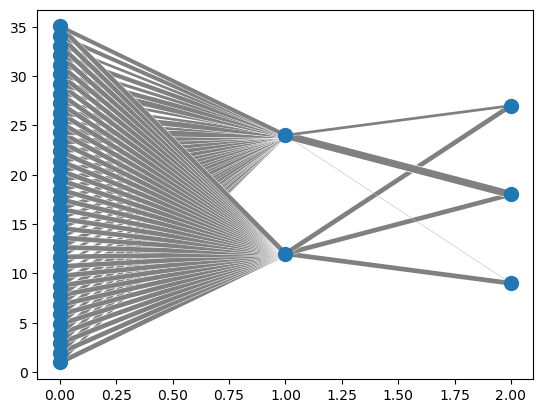

In [190]:
visualise(mlp)

Evaluate on validation set

In [191]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

val_pred = mlp.predict(X_val)
print("Baseline model accuracy: ", accuracy_score(y_val, val_pred))

Baseline model accuracy:  0.5


Model fine-tuning and validation

In [192]:
hidden_layers = [(60,20,10),(128,64,32)]
activations = ['identity', 'logistic', 'tanh', 'relu']
learning_rates = [0.001, 0.01]
alphas = [0.0001, 0.001]

results = []

for h in hidden_layers:
    for act in activations:
        for lr in learning_rates:
            for a in alphas:
                model = MLPClassifier(
                    hidden_layer_sizes=h,
                    activation=act,
                    learning_rate_init=lr,
                    alpha=a,
                    max_iter=5000,
                    early_stopping=True,
                    random_state=42
                )
                
                model.fit(X_train, y_train)
                pred = model.predict(X_val)
                acc = accuracy_score(y_val, pred)

                results.append((h, act, lr, a, acc))
                print(f"{h}, {act}, lr={lr}, alpha={a} -> Val Accuracy {acc:.4f}")

(60, 20, 10), identity, lr=0.001, alpha=0.0001 -> Val Accuracy 0.5015
(60, 20, 10), identity, lr=0.001, alpha=0.001 -> Val Accuracy 0.6551
(60, 20, 10), identity, lr=0.01, alpha=0.0001 -> Val Accuracy 0.7078
(60, 20, 10), identity, lr=0.01, alpha=0.001 -> Val Accuracy 0.7244
(60, 20, 10), logistic, lr=0.001, alpha=0.0001 -> Val Accuracy 0.5000
(60, 20, 10), logistic, lr=0.001, alpha=0.001 -> Val Accuracy 0.5000
(60, 20, 10), logistic, lr=0.01, alpha=0.0001 -> Val Accuracy 0.5000
(60, 20, 10), logistic, lr=0.01, alpha=0.001 -> Val Accuracy 0.5000
(60, 20, 10), tanh, lr=0.001, alpha=0.0001 -> Val Accuracy 0.5030
(60, 20, 10), tanh, lr=0.001, alpha=0.001 -> Val Accuracy 0.5045
(60, 20, 10), tanh, lr=0.01, alpha=0.0001 -> Val Accuracy 0.5105
(60, 20, 10), tanh, lr=0.01, alpha=0.001 -> Val Accuracy 0.5045
(60, 20, 10), relu, lr=0.001, alpha=0.0001 -> Val Accuracy 0.6551
(60, 20, 10), relu, lr=0.001, alpha=0.001 -> Val Accuracy 0.6777
(60, 20, 10), relu, lr=0.01, alpha=0.0001 -> Val Accuracy

In [195]:
best_model = MLPClassifier(
    hidden_layer_sizes=(60, 20, 10),
    activation='identity',
    max_iter=5000,
    random_state=42
)

best_model.fit(X_train, y_train)

MLPClassifier(activation='identity', hidden_layer_sizes=(60, 20, 10),
              max_iter=5000, random_state=42)

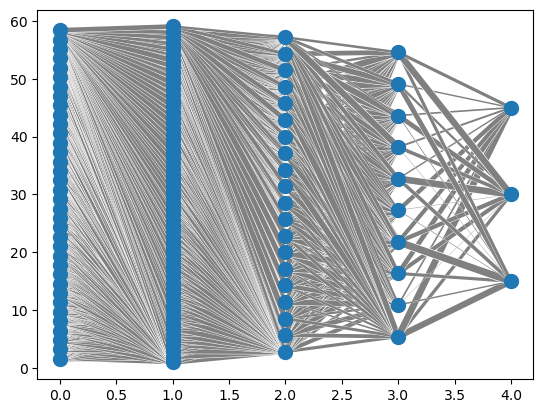

In [196]:
visualise(best_model)

In [197]:
test_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred))

Test Accuracy: 0.7243975903614458
              precision    recall  f1-score   support

     Dropout       0.71      0.82      0.76       214
    Enrolled       0.67      0.02      0.03       119
    Graduate       0.73      0.92      0.81       331

    accuracy                           0.72       664
   macro avg       0.70      0.58      0.54       664
weighted avg       0.71      0.72      0.66       664



Model Inferencing

In [198]:
comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': test_pred
})

pd.set_option('display.max_rows', None)
print("\nComparison DataFrame")
print(comparison_df)



Comparison DataFrame
       Actual Predicted
0    Graduate  Graduate
1     Dropout   Dropout
2    Graduate  Graduate
3    Graduate  Graduate
4     Dropout   Dropout
5    Graduate  Graduate
6    Graduate  Graduate
7    Graduate  Graduate
8    Graduate  Graduate
9    Enrolled   Dropout
10   Graduate  Graduate
11   Graduate  Graduate
12   Graduate  Graduate
13   Enrolled   Dropout
14   Graduate  Graduate
15   Graduate  Graduate
16   Graduate  Graduate
17   Graduate  Graduate
18   Graduate  Graduate
19    Dropout   Dropout
20    Dropout  Graduate
21   Graduate  Graduate
22    Dropout   Dropout
23    Dropout   Dropout
24    Dropout   Dropout
25    Dropout  Graduate
26    Dropout   Dropout
27   Graduate  Graduate
28   Graduate  Graduate
29   Enrolled   Dropout
30   Graduate  Graduate
31   Enrolled  Graduate
32   Enrolled  Graduate
33    Dropout   Dropout
34    Dropout   Dropout
35   Graduate  Graduate
36   Graduate  Graduate
37   Enrolled  Graduate
38    Dropout   Dropout
39    Dropout   Dr

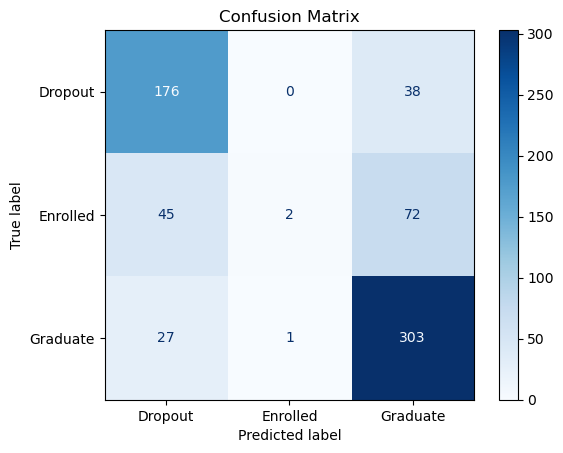

In [199]:
labels = ['Dropout', 'Enrolled', 'Graduate']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()
